In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pytz

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation

from astroplan import Observer, FixedTarget, time_grid_from_range, observability_table, moon_illumination
from astroplan import is_observable, is_always_observable, months_observable
from astroplan import AirmassConstraint, MoonSeparationConstraint, AtNightConstraint
from astroplan import download_IERS_A
from astropy.coordinates import get_sun, get_body, get_moon
from astroplan.plots import plot_sky, plot_airmass

download_IERS_A()

import warnings
warnings.filterwarnings('ignore', category=Warning)

In [66]:
#reads in the data as a panda table and registers the first row as a comment

quasar_table = pd.read_csv('QuasarData.csv', comment = "#")

In [67]:
#new dataframe in which the three nonapplicable columns are dropped
#axis=1 tells panda that it should drop columns and not rows

df = quasar_table.drop(['plate','mjd','fiberid'], axis=1)

In [68]:
#creates a new table of a masked dataframe in which only objects viewable from lick are included

mask = ((df['ra'] > 8.0) & (df['ra'] < 15.0) &
         (df['dec'] > -25.0) & (df['dec'] < 45))

masked_df = df[mask].reset_index(drop=True)
len(masked_df)

16

In [69]:
#converts the table into a matrix array so that the fixedtarget function may work

masked_table = masked_df.as_matrix()

targets = [FixedTarget(coord=SkyCoord(ra = ra*u.hourangle, dec = dec*u.deg), name=specobjid)
           for specobjid, ra, dec in masked_table]
targets

[<FixedTarget "7.926588067262996e+18" at SkyCoord (ICRS): (ra, dec) in deg (162.109845, -3.9946159)>,
 <FixedTarget "6.419916282682909e+18" at SkyCoord (ICRS): (ra, dec) in deg (216.36897, 17.940253)>,
 <FixedTarget "4.0421473288359526e+18" at SkyCoord (ICRS): (ra, dec) in deg (170.00595, 0.55651717)>,
 <FixedTarget "4.042233365620826e+18" at SkyCoord (ICRS): (ra, dec) in deg (194.41185, 0.90176525)>,
 <FixedTarget "4.717878254953042e+17" at SkyCoord (ICRS): (ra, dec) in deg (170.5719, 13.65242)>,
 <FixedTarget "6.985219190970884e+18" at SkyCoord (ICRS): (ra, dec) in deg (171.04305, 16.618724)>,
 <FixedTarget "4.754916465974419e+18" at SkyCoord (ICRS): (ra, dec) in deg (187.514145, 0.68402922)>,
 <FixedTarget "6.98529780605227e+18" at SkyCoord (ICRS): (ra, dec) in deg (189.08598, 18.192752)>,
 <FixedTarget "1.2193966455112602e+18" at SkyCoord (ICRS): (ra, dec) in deg (218.359875, -0.28170282)>,
 <FixedTarget "4.042252607074312e+18" at SkyCoord (ICRS): (ra, dec) in deg (199.80087, 0.092

In [70]:
#defines the observatory and window using astroplan snazziness
lick = Observer.at_site('Lick observatory')
lick.timezone = pytz.timezone('US/Pacific')

for i in range(1,14):
    window = Time("2019-04-{0} 12:00:00".format(i))
    observe_start = lick.twilight_evening_astronomical(window, which='nearest')
    observe_end = lick.twilight_morning_astronomical(window, which='next')
    ob_length = (observe_end - observe_start).to(u.hr)
    print("Obs at Lick starts at {0.iso} UTC, ends at {1.iso} UTC, runs for {2:.2f}".format(observe_start, observe_end, ob_length))
    print("Moon brightness at {0:.2f} fullness".format(moon_illumination(observe_start)))

Obs at Lick starts at 2019-04-01 03:57:13.589 UTC, ends at 2019-04-01 12:23:23.291 UTC, runs for 8.44 h
Moon brightness at 0.16 fullness
Obs at Lick starts at 2019-04-02 03:58:19.134 UTC, ends at 2019-04-02 12:21:42.830 UTC, runs for 8.39 h
Moon brightness at 0.09 fullness
Obs at Lick starts at 2019-04-03 03:59:25.054 UTC, ends at 2019-04-03 12:20:02.399 UTC, runs for 8.34 h
Moon brightness at 0.05 fullness
Obs at Lick starts at 2019-04-04 04:00:31.346 UTC, ends at 2019-04-04 12:18:21.340 UTC, runs for 8.30 h
Moon brightness at 0.02 fullness
Obs at Lick starts at 2019-04-05 04:01:38.006 UTC, ends at 2019-04-05 12:16:39.854 UTC, runs for 8.25 h
Moon brightness at 0.00 fullness
Obs at Lick starts at 2019-04-06 04:02:45.028 UTC, ends at 2019-04-06 12:14:58.490 UTC, runs for 8.20 h
Moon brightness at 0.01 fullness
Obs at Lick starts at 2019-04-07 04:03:52.405 UTC, ends at 2019-04-07 12:13:17.288 UTC, runs for 8.16 h
Moon brightness at 0.03 fullness
Obs at Lick starts at 2019-04-08 04:05:00

In [71]:
observing_range = [observe_start, observe_end]

constraints = [AtNightConstraint.twilight_astronomical()]

In [11]:
#moon separation from target must be larger than 35 degrees

moon_illumination(observe_start)
constraints.append(MoonSeparationConstraint(35*u.deg))

In [12]:
observing_table = observability_table(constraints, lick, targets, time_range=observing_range)

print(observing_table)

     target name       ever observable ... fraction of time observable
---------------------- --------------- ... ---------------------------
 7.926588067262996e+18            True ...          0.2862957937584803
 6.419916282682909e+18            True ...          0.3487109905020353
4.0421473288359526e+18            True ...         0.30257801899592945
 4.042233365620826e+18            True ...         0.32700135685210313
 4.717878254953042e+17            True ...          0.2835820895522388
 6.985219190970884e+18            True ...          0.2835820895522388
 4.754916465974419e+18            True ...         0.32700135685210313
  6.98529780605227e+18            True ...          0.3202170963364993
1.2193966455112602e+18            True ...          0.3487109905020353
 4.042252607074312e+18            True ...         0.33921302578018997
4.0411052664390697e+18            True ...         0.30529172320217096
4.0399887123475087e+18            True ...          0.2862957937584803
 4.756

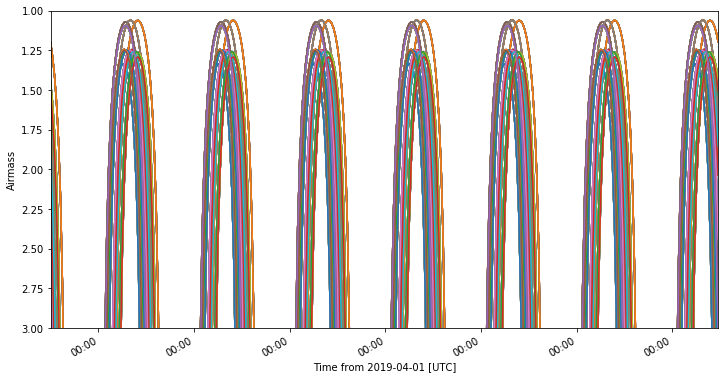

In [35]:
ob_time = observe_start + np.linspace(0,48,75)*u.hour
window_range = [window(0), window(15)]
window_time_grid = time_grid_from_range(window_range)

fig,ax = plt.subplots(1,1)
fig.set_size_inches(10,5)

fig.tight_layout()

for i, my_object in enumerate(targets):

    if observing_table['ever observable'][i]:
        ax = plot_airmass(targets, lick, window_time_grid)

ax.vlines(observe_start.datetime, 1,3, color='r', linewidth=5)
ax.vlines(observe_end.datetime, 1,3, color='r', linewidth=5)

#ax.legend(loc=0,shadow=True);

In [72]:
for i in range(1,14):
    window = Time("2019-05-{0} 12:00:00".format(i))
    observe_start = lick.twilight_evening_astronomical(window, which='nearest')
    observe_end = lick.twilight_morning_astronomical(window, which='next')
    ob_length = (observe_end - observe_start).to(u.hr)
    print("Obs at Lick starts at {0.iso} UTC, ends at {1.iso} UTC, runs for {2:.2f}".format(observe_start, observe_end, ob_length))
    print("Moon brightness at {0:.2f} fullness".format(moon_illumination(observe_start)))

Obs at Lick starts at 2019-05-01 04:33:05.336 UTC, ends at 2019-05-02 11:32:24.201 UTC, runs for 30.99 h
Moon brightness at 0.14 fullness
Obs at Lick starts at 2019-05-02 04:34:22.463 UTC, ends at 2019-05-03 11:30:54.428 UTC, runs for 30.94 h
Moon brightness at 0.08 fullness
Obs at Lick starts at 2019-05-03 04:35:39.860 UTC, ends at 2019-05-04 11:29:23.897 UTC, runs for 30.90 h
Moon brightness at 0.03 fullness
Obs at Lick starts at 2019-05-04 04:36:58.737 UTC, ends at 2019-05-05 11:27:54.707 UTC, runs for 30.85 h
Moon brightness at 0.01 fullness
Obs at Lick starts at 2019-05-05 04:38:17.485 UTC, ends at 2019-05-06 11:26:26.899 UTC, runs for 30.80 h
Moon brightness at 0.00 fullness
Obs at Lick starts at 2019-05-06 04:39:36.054 UTC, ends at 2019-05-07 11:25:00.513 UTC, runs for 30.76 h
Moon brightness at 0.02 fullness
Obs at Lick starts at 2019-05-07 04:40:54.391 UTC, ends at 2019-05-08 11:23:35.589 UTC, runs for 30.71 h
Moon brightness at 0.06 fullness
Obs at Lick starts at 2019-05-08 0

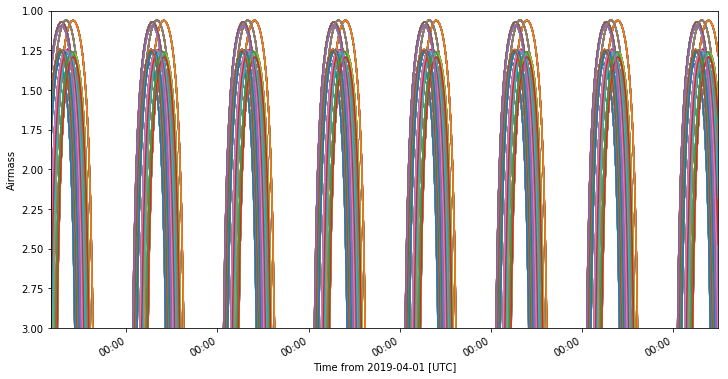

In [74]:
ob_time = observe_start + np.linspace(0,48,75)*u.hour
window_range = [Time("2019-04-01 4:00:00"),Time("2019-04-8 12:00:00")]
window_time_grid = time_grid_from_range(window_range)

fig,ax = plt.subplots(1,1)
fig.set_size_inches(10,5)

fig.tight_layout()

for i, my_object in enumerate(targets):

    if observing_table['ever observable'][i]:
        ax = plot_airmass(targets, lick, window_time_grid)

ax.vlines(observe_start.datetime, 1,3, color='r', linewidth=5)
ax.vlines(observe_end.datetime, 1,3, color='r', linewidth=5)